# Data Simulation with `msprime`

This notebook introduces the `msprime` simulator, a high‑performance library for generating ancestry and mutation data under the coalescent. Version 1.0 supports separate ancestry and mutation simulation via the succinct tree sequence data structure. `msprime` is widely used in population genetics because it can simulate whole chromosomes efficiently and stores results compactly using `tskit`.

## Simulating a constant population

We simulate a chromosome of length 5 Mb with a constant effective population size of 10,000 individuals. We set the mutation and recombination rates to 1e-8 per base per generation.

In [1]:
import msprime
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Parameters
sequence_length = 5_000_000
ne = 10000
mutation_rate = 1e-8
recombination_rate = 1e-8
samples = 10  # number of diploid individuals

# Demography: constant population
demography = msprime.Demography()
demography.add_population(initial_size=ne)

# Simulate ancestry and mutations
ts_anc = msprime.sim_ancestry(samples=samples,
                            recombination_rate=recombination_rate,
                            sequence_length=sequence_length,
                            demography=demography)
ts = msprime.sim_mutations(ts_anc, rate=mutation_rate)

print('Tree sequence has', ts.num_sites, 'segregating sites and', ts.num_trees, 'trees.')

Tree sequence has 6883 segregating sites and 5573 trees.


In [8]:
# SNP
genotypes = ts.genotype_matrix()
print('Genotype matrix shape:', genotypes)

Genotype matrix shape: [[0 0 0 ... 0 1 0]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


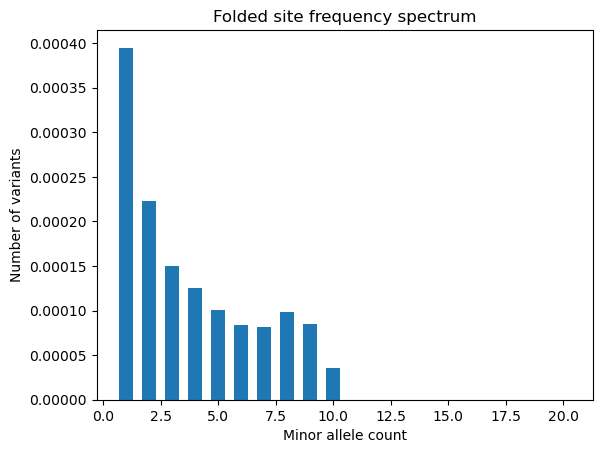

In [10]:
# Compute and plot the folded SFS
sfs = ts.allele_frequency_spectrum()
freqs = np.arange(1, len(sfs))
plt.bar(freqs, sfs[1:], width=0.6)
plt.xlabel('Minor allele count')
plt.ylabel('Number of variants')
plt.title('Folded site frequency spectrum')
plt.show()